# KarateClub
Credit: Alex Smola et al. @KDD'19

In [2]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

In [3]:
import dgl
import torch
# Load PyTorch as backend
dgl.load_backend('pytorch')

In [4]:
import networkx as nx

G = dgl.DGLGraph(nx.karate_club_graph())

In [5]:
print('#Nodes', G.number_of_nodes())
print('#Edges', G.number_of_edges())

#Nodes 34
#Edges 156


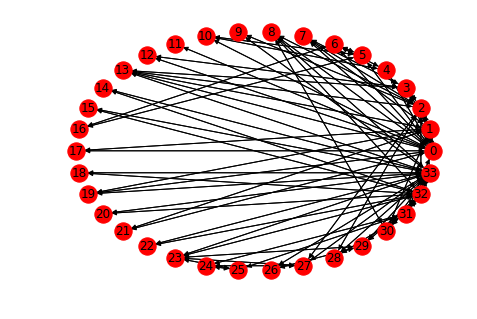

In [6]:
nx_G = G.to_networkx()
pos = nx.circular_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

In [7]:
G.ndata['feat'] = torch.randn((34, 5))

In [8]:
G.edata['broness'] = torch.ones((G.number_of_edges(),))

In [9]:
# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

print(G.edata)

{'broness': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.00

In [10]:
import dgl.function as fn
message_func = fn.copy_u('h', 'm')

In [11]:
reduce_func = fn.sum('m', 'h')

In [12]:
# Same message function as `fn.copy_u`
def gcn_message_udf(edges):
    return {'m' : edges.src['h']}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(nodes):
    return {'h' : nodes.mailbox['m'].sum(1)}

In [13]:
# Message function with normalization
def gcn_message_udf(g):
    return {'m' : g.src['h'] / torch.sqrt(g.src['norm']).reshape(-1, 1)}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(g):
    return {'h' : g.mailbox['m'].sum(1)}

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Define the GraphConv module
class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h

        # trigger message passing, using the defined message_func and reduce_func.
#        g.update_all(message_func, reduce_func)

        # Use normalized functions
        g.ndata['norm'] = g.in_degrees(g.nodes()).float()
        g.update_all(gcn_message_udf, gcn_reduce_udf)
        # get the result node features
        h = g.ndata.pop('h')
        return h

In [15]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GraphConv(in_feats, hidden_size)
        self.gcn2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

In [16]:
inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [17]:
net = GCN(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

all_logits = []
for epoch in range(100):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7914
Epoch 1 | Loss: 0.7846
Epoch 2 | Loss: 0.7780


C:\Anaconda3\envs\ml\lib\site-packages\dgl\base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 3 | Loss: 0.7716
Epoch 4 | Loss: 0.7654
Epoch 5 | Loss: 0.7595
Epoch 6 | Loss: 0.7537
Epoch 7 | Loss: 0.7482
Epoch 8 | Loss: 0.7429
Epoch 9 | Loss: 0.7378
Epoch 10 | Loss: 0.7329
Epoch 11 | Loss: 0.7282
Epoch 12 | Loss: 0.7237
Epoch 13 | Loss: 0.7194
Epoch 14 | Loss: 0.7153
Epoch 15 | Loss: 0.7112
Epoch 16 | Loss: 0.7073
Epoch 17 | Loss: 0.7035
Epoch 18 | Loss: 0.6999
Epoch 19 | Loss: 0.6964
Epoch 20 | Loss: 0.6930
Epoch 21 | Loss: 0.6896
Epoch 22 | Loss: 0.6864
Epoch 23 | Loss: 0.6833
Epoch 24 | Loss: 0.6803
Epoch 25 | Loss: 0.6774
Epoch 26 | Loss: 0.6746
Epoch 27 | Loss: 0.6718
Epoch 28 | Loss: 0.6691
Epoch 29 | Loss: 0.6665
Epoch 30 | Loss: 0.6639
Epoch 31 | Loss: 0.6614
Epoch 32 | Loss: 0.6589
Epoch 33 | Loss: 0.6564
Epoch 34 | Loss: 0.6540
Epoch 35 | Loss: 0.6516
Epoch 36 | Loss: 0.6491
Epoch 37 | Loss: 0.6467
Epoch 38 | Loss: 0.6443
Epoch 39 | Loss: 0.6418
Epoch 40 | Loss: 0.6394
Epoch 41 | Loss: 0.6369
Epoch 42 | Loss: 0.6345
Epoch 43 | Loss: 0.6320
Epoch 44 | Loss: 0.6295

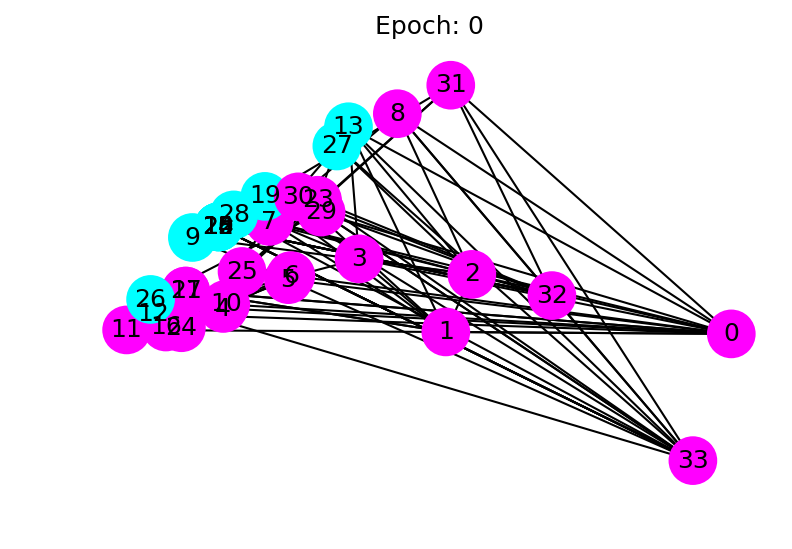

In [21]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = G.to_networkx()
    
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
      
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

In [19]:
with open("karate_club.html", "w") as f:
    print(ani.to_html5_video(), file=f)